Link to GitHub page: https://kdors.github.io

<h1><center>NFL Suspensions & Elo Ratings</center></h1>
 <center><strong>By Kennedy Dorsey</strong></center>


## Introduction

NFL suspensions happen for a variety of reasons, but many of those reasons can be divided up into a few categories. A main cause for suspension, as shown by the data below, is drug use. Drug use can be divided into two categories: substance abuse and the use of performance enhancing drugs (PEDs). Substance abuse refers to the "illegal possession, use, or distribution of alcohol or drugs". PED use refers to the "possession, use, or distribution of steriods or other performance enhancing substances". Many players use PEDs to enhance their abilities, especially when performing well is critical to staying in the NFL (as opposed to contracts in the NBA or MLB). Regarding the use of these drugs, one question that comes to mind is how well do teams that have players using PEDs perform, and how do different suspension types compare to one another in terms of the number of games suspended and the fine associated with that suspension. 

This tutorial aims to uncover any relationships between different types of NFL suspensions, as well as any relationship between NFL suspensions involving drug use (more specifically PED use) and the winningness of a team, if there are any. I was inspired to do this tutorial by a FiveThirtyEight article that examined the NFL's light treatment of domestic violence (Read more about it here: https://fivethirtyeight.com/features/nfl-domestic-violence-policy-suspensions/). In the same vein, I want to see if there is any difference in the way drug use is treated versus other suspension types. One thing to note is that the analysis that is done is based off of suspensions that are reported by teams to the NFL. There are probably plenty of players who get away with violating NFL player rules, and so that data is absent from this analysis. This analysis then focuses on players who were caught.

Since I want to focus my analysis on drug use specifically, I divide NFL suspension types into three categories: PED use, substance abuse, and everything else. At times I group PED use and substance abuse into one category: drug use. 

For this tutorial, two sources are used to obtain the data that I will use. 


## Data Collection and Processing

Data Sources:

https://github.com/fivethirtyeight/data/tree/master/nfl-suspensions

https://www.spotrac.com/nfl/fines-suspensions/suspensions/

The first dataset, created by FiveThirtyEight, provides information about each game in the NFL from 1920 to 2019. This information includes the home team name, the away team name, the scores for both teams, whether it was a playoff game or not, and Elo probabilities for the home team and the away team. This dataset includes other Elo measures as well, however, scoring and Elo probabilties is the data that this tutorial will use. Elo ratings are ratings based off of the Elo rating system, created by physics professor Arpad Elo. These ratings are used to show which teams are more likely to win regular-season and playoff games. More information about Elo ratings and its history can be found at: https://fivethirtyeight.com/features/introducing-nfl-elo-ratings/.  

The second dataset is a concatenation of multiple tables found at the website https://www.spotrac.com/nfl/fines-suspensions/suspensions/. These tables document suspensions that happen in the NFL for every season from 2002 to 2019. The information provided includes the player's name, position, games forfeited, fine amount, and suspension reason. 

Libraries used: 
- Pandas
- Numpy
- Beautiful Soup 4
- Requests
- Matplotlib
- Seasborn
- Scipy

**Note:** lxml is needed to parse html

In [ ]:
!pip install lxml

In [1]:
# import libraries
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

### FiveThirtyEight Elo Ratings Data Processing

First, the csv file from FiveThirtyEight is read in. The only columns that are kept are date, season, a column indicating whether the game is a playoff game or not, and the columns involing the Elo ratings of the team as a whole before and after each game, and the Elo probability before and after each game. 

For this tutorial, I am only looking at seasons from 2002 to 2018, the same seasons that I have suspensions data for, so the dataset is filtered to only include these years. I also only include regular season games.

Even though the 2019 season is not over, FiveThirtyEight has already calculated the Elo probabilties for each game through the end of the season, so when looking at the average team probability, we are looking at the average over the years 2002 to 2019 for 8 games away and 8 games at home for each team. 

In [2]:
df_nfl_elo = pd.read_csv('./data/nfl_elo.csv')

# date column is datetime
# change date column to datetime 
df_nfl_elo['date'] = pd.to_datetime(df_nfl_elo['date'])

# drop columns that aren't used in analysis
df_nfl_elo = df_nfl_elo[['date','playoff','season','team1','team2','elo1_pre','elo2_pre','elo1_post','elo2_post','elo_prob1','elo_prob2','score1','score2']]

# only using regular season games for years 2000 and after
df_nfl_elo['playoff'] = df_nfl_elo['playoff'].fillna('no')
df_nfl_elo = df_nfl_elo[df_nfl_elo['playoff'] == 'no']
df_nfl_elo = df_nfl_elo[df_nfl_elo['season'] >= 2002 ]

# display
display(df_nfl_elo)

# check dtypes
df_nfl_elo.info()

,date,playoff,season,team1,team2,elo1_pre,elo2_pre,elo1_post,elo2_post,elo_prob1,elo_prob2,score1,score2
11735,2002-09-05,no,2002,NYG,SF,1485.669000,1561.242000,1472.292,1574.619,0.484789,0.515211,13.0,16.0
11736,2002-09-08,no,2002,TEN,PHI,1516.957000,1613.455000,1532.293,1598.119,0.454795,0.545205,27.0,24.0
11737,2002-09-08,no,2002,CAR,BAL,1370.952000,1572.940000,1391.280,1552.612,0.312477,0.687523,10.0,7.0
11738,2002-09-08,no,2002,JAX,IND,1484.758000,1492.006000,1468.177,1508.587,0.582355,0.417645,25.0,28.0
11739,2002-09-08,no,2002,HOU,DAL,1300.000000,1425.973000,1327.796,1398.177,0.413143,0.586857,19.0,10.0
11740,2002-09-08,no,2002,BUF,NYJ,1413.251000,1535.438000,1397.379,1551.311,0.418437,0.581563,31.0,37.0
11741,2002-09-08,no,2002,WSH,ARI,1518.146000,1428.844000,1530.115,1416.875,0.708526,0.291474,31.0,23.0
11742,2002-09-08,no,2002,CHI,MIN,1565.787000,1452.964000,1573.659,1445.092,0.735679,0.264321,27.0,23.0
11743,2002-09-08,no,2002,TB,NO,1547.200000,1450.990000,1517.103,1481.087,0.716669,0.283331,20.0,26.0
11744,2002-09-08,no,2002,CLE,KC,1446.242000,1475.100000,1438.464,1482.878,0.551826,0.448174,39.0,40.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4608 entries, 11735 to 16529
Data columns (total 13 columns):
date         4608 non-null datetime64[ns]
playoff      4608 non-null object
season       4608 non-null int64
team1        4608 non-null object
team2        4608 non-null object
elo1_pre     4608 non-null float64
elo2_pre     4608 non-null float64
elo1_post    4500 non-null float64
elo2_post    4500 non-null float64
elo_prob1    4608 non-null float64
elo_prob2    4608 non-null float64
score1       4500 non-null float64
score2       4500 non-null float64
dtypes: datetime64[ns](1), float64(8), int64(1), object(3)
memory usage: 504.0+ KB


### NFL Suspensions Data Processing

To read in the yearly suspension data found on separate urls, I used Beautiful Soup 4 to find the html tables. The individual tables are read in as dataframes and then concatenated into one. Because of the way the data is read in, some columns are read in as one column, so those need to be split. An empty column that is generated needs to be removed. Also, the 'Forfeits' and 'Fine' columns' dtypes are changed to int and float, respectively. 

Because the 'Infraction' column is composed of strings that are different variations of one another depending on the suspension type, I combined all of the strings that mentioned PEDs, all of the strings that involved substance abuse, and left the rest as is. As defined by the NFL's personal conduct policy, PED use and substance abuse falls under the umbrella of personal conduct violations along with twelve or so other rules (Read more about NFL's personal conduct  policy here: https://static.nfl.com/static/content/public/photo/2017/08/11/0ap3000000828506.pdf). However, since it is impossible to know whether a suspension labeled as 'personal conduct violation' is actually related to drug use or not, I did not include those labels into the PED or substance abuse categories. Likewise, the drug use boolean that I create only includes those violations that are categorized as either PED or substance abuse. So, then this tutorial is analyzing those violations that are explicitly labeled as either PED or substance abuse versus the broader umbrella of all NFL violations. 

Because I will be comparing this dataset involving suspension data to the FiveThirtyEight dataset, some team name abbreviations needed to be changed in order to match those in the FiveThirtyEight dataset, as well to account for NFL team location changes.

When analyzing trends over the years, it is important to remember that the year 2019 does not include all 16 games like the rest of the years do. So, 2019 is only representative of the games that have already taken place (as of November 2019).

In [3]:
import requests
from bs4 import BeautifulSoup

urls = ['https://www.spotrac.com/nfl/fines-suspensions/2002/suspensions/',
        'https://www.spotrac.com/nfl/fines-suspensions/2003/suspensions/',
        'https://www.spotrac.com/nfl/fines-suspensions/2004/suspensions/',
        'https://www.spotrac.com/nfl/fines-suspensions/2005/suspensions/',
        'https://www.spotrac.com/nfl/fines-suspensions/2006/suspensions/',
        'https://www.spotrac.com/nfl/fines-suspensions/2007/suspensions/',
        'https://www.spotrac.com/nfl/fines-suspensions/2008/suspensions/',
        'https://www.spotrac.com/nfl/fines-suspensions/2009/suspensions/',
        'https://www.spotrac.com/nfl/fines-suspensions/2010/suspensions/',
        'https://www.spotrac.com/nfl/fines-suspensions/2011/suspensions/',
        'https://www.spotrac.com/nfl/fines-suspensions/2012/suspensions/',
        'https://www.spotrac.com/nfl/fines-suspensions/2013/suspensions/',
        'https://www.spotrac.com/nfl/fines-suspensions/2014/suspensions/',
        'https://www.spotrac.com/nfl/fines-suspensions/2015/suspensions/',
        'https://www.spotrac.com/nfl/fines-suspensions/2016/suspensions/',
        'https://www.spotrac.com/nfl/fines-suspensions/2017/suspensions/',
        'https://www.spotrac.com/nfl/fines-suspensions/2018/suspensions/',
        'https://www.spotrac.com/nfl/fines-suspensions/suspensions/']

df_list = []
data_year = 2002

for url in urls:
    r = requests.get(url)
    spotrac_bs = BeautifulSoup(r.content, 'html.parser')

    # find table 
    spotrac_t = spotrac_bs.find_all('table')
    spotrac_t[1]

    nfl_sus = pd.read_html(spotrac_t[1].prettify())
    nfl_sus = nfl_sus[0]
    
    nfl_sus['year'] = data_year
    
    # drop last row that has column summary info
    nfl_sus = nfl_sus.drop(len(nfl_sus)-1)
    
    df_list.append(nfl_sus)
    
    data_year += 1

# concat suspension dataframes
nfl_sus = pd.concat(df_list)
display(nfl_sus)

,Player,Pos.,Team,Forfeits,Unnamed: 4,year
0,Julius Peppers violating the NFL's substance ...,DE,CAR,"4 games ($250,000.00)",NaN,2002
1,Rodney Harrison hit the the head against Jerr...,S,SD,"1 game ($111,764.00)",NaN,2002
2,R. Jay Soward Substance Abuse,WR,JAC,"16 games ($735,000.00)",NaN,2002
3,Rashard Anderson Substance Abuse,CB,CAR,"32 games ($1,173,125.00)",NaN,2002
4,Victor Riley Personal Conduct,LT,NO,"1 game ($30,882.00)",NaN,2002
0,William Green Substance Abuse,RB,CLE,"8 games ($141,176.00)",NaN,2003
1,Scott Shanle violating the NFL's substance ab...,LB,STL,"4 games ($52,941.00)",NaN,2003
2,David Boston Conduct detrimental to the team,WR,SD,"1 game ($32,353.00)",NaN,2003
0,David Boston Violating the league's steroid p...,WR,MIA,"4 games ($125,882.00)",NaN,2004
1,Wendell Bryant Violating the league's substan...,DT,ARI,"4 games ($89,412.00)",NaN,2004


In [4]:
# split Player and Infraction into two columns
new = nfl_sus["Player"].str.split(" ", n = 2, expand = True) 
nfl_sus["Player"]= new[0] + " " + new[1] 
nfl_sus["Infraction"]= new[2] 

# split Forfeits and Fine into two columns
new = nfl_sus["Forfeits"].str.split("(", n = 1, expand = True) 
nfl_sus["Forfeits"]= new[0]
nfl_sus["Fine"]= new[1] 

#remove $ and ) from Fine column
nfl_sus["Fine"] = nfl_sus["Fine"].str.slice(start=1,stop=-1)
    
# drop unnecessary column
nfl_sus.drop(columns=['Unnamed: 4'], inplace=True)
    
# Change Forfeits column to int
new = nfl_sus["Forfeits"].str.split(" ", n=1, expand=True)
nfl_sus['Forfeits'] = new[0]
nfl_sus['Forfeits'] = nfl_sus['Forfeits'].astype(int)

# Change Fine column to float
nfl_sus['Fine']= nfl_sus['Fine'].replace(regex=True,to_replace=r',',value="")
nfl_sus['Fine'] =  nfl_sus['Fine'].astype(float)

In [5]:
# Merge all variations of peds and substance abuse into two categories
peds = [" violation of the league's policy on performance enhancing drugs",
    ' PEDs',' PED'," Violating the NFL's Performing Enhancing Drugs policy",
    " Violating the league's policy on performance-enhancing substances",
    ' performance-enhancing substances',
    ' PEDs (2nd offense)', " Violating the league's PED policy"," Violating the NFL's PED policy",
     " Violating the league's PED Policy", ' PEDs (adderall)', " PED's",' PEDS', 'Jr.  PEDs', 
     ' performance enhancing drugs', " Violating the NFL's performance-enhancing drug policy",
    " Violating the league's steroid policy", ' Banned Substance', " Violating the NFL's policy on PEDs",
    ' Performance Enhancing Drug Abuse']

nfl_sus['Infraction'] = nfl_sus['Infraction'].replace(peds,"peds")

sub_abuse =  [' Substance Abuse',' Substance Abuse/Personal Conduct'," Violating the NFL's substance abuse policy",
             ' Repeat Offender - Substance Abuse (Marijuana)',' Substance Abuse (Marijuana)',
             ' for the first four games of the 2013 regular season for violating the NFL Policy and Program for Substances of Abuse',
             " Violating the NFL's substance abuse and personal conduct policy",
             " Violating the league's substance abuse policy",
             ' Violating the Substance Abuse policy',
             ' Violating the Substance Abuse Policy',
             ' Suspended the entire season for substance abuse (2nd offense)',
             ' Violating the Substance-Abuse Policy', ' Substance abuse',
             " VIolating the league's Substance Abuse policy", ' Substance Abuse (adderall)', 
             'Hill  Substance Abuse',  ' Substance Abuse (marijuana)',
             ' Personal Conduct & Substance Abuse', " violating the NFL's substance abuse policy",
             'Soward  Substance Abuse', ' Violating the substance abuse policy', 
             ' violating the Minor League Drug Prevention and Treatment Program']

nfl_sus['Infraction'] = nfl_sus['Infraction'].replace(sub_abuse,"sub abuse")


# change team names
nfl_sus['Team'] = nfl_sus['Team'].replace({'SD': 'LAC', 'JAC': 'JAX', 'STL': 'LAR', 'WAS': 'WSH'})

#check that team names match between dataframes
set(pd.unique(df_nfl_elo['team1'])) == set(pd.unique(df_nfl_elo['team2'])) == set(pd.unique(nfl_sus['Team']))

True

To finish preprocessing this dataset, I add three columns: peds_bool, sub_abuse_bool, and drug_use_bool that indicate 
whether an observation is PED related, substance abuse related, or whether it is drug related in general.

In [6]:
# define boolean columsn peds_bool, sub_abuse_bool, and drug_use_bool
def map_peds(x):
    if x == 'peds':
        return '1'
    else:
        return '0'

def map_sub_abuse(x):
    if x == 'sub abuse':
        return '1'
    else:
        return '0'

def map_drugs(x):
    if (x == 'sub abuse') | ( x == 'peds'):
        return '1'
    else:
        return '0'

nfl_sus['peds_bool'] = nfl_sus['Infraction']
nfl_sus['peds_bool'] = nfl_sus['peds_bool'].apply(map_peds)

nfl_sus['sub_abuse_bool'] = nfl_sus['Infraction']
nfl_sus['sub_abuse_bool'] = nfl_sus['sub_abuse_bool'].apply(map_sub_abuse)

nfl_sus['drug_use_bool'] = nfl_sus['Infraction']
nfl_sus['drug_use_bool'] = nfl_sus['drug_use_bool'].apply(map_drugs)

#display tidy dataframe and dtypes
display(nfl_sus)

print(nfl_sus.info())
    

,Player,Pos.,Team,Forfeits,year,Infraction,Fine,peds_bool,sub_abuse_bool,drug_use_bool
0,Julius Peppers,DE,CAR,4,2002,sub abuse,250000.00,0,1,1
1,Rodney Harrison,S,LAC,1,2002,hit the the head against Jerry Rice (OAK),111764.00,0,0,0
2,R. Jay,WR,JAX,16,2002,sub abuse,735000.00,0,1,1
3,Rashard Anderson,CB,CAR,32,2002,sub abuse,1173125.00,0,1,1
4,Victor Riley,LT,NO,1,2002,Personal Conduct,30882.00,0,0,0
0,William Green,RB,CLE,8,2003,sub abuse,141176.00,0,1,1
1,Scott Shanle,LB,LAR,4,2003,sub abuse,52941.00,0,1,1
2,David Boston,WR,LAC,1,2003,Conduct detrimental to the team,32353.00,0,0,0
0,David Boston,WR,MIA,4,2004,peds,125882.00,1,0,1
1,Wendell Bryant,DT,ARI,4,2004,sub abuse,89412.00,0,1,1


<class 'pandas.core.frame.DataFrame'>
Int64Index: 539 entries, 0 to 53
Data columns (total 10 columns):
Player            539 non-null object
Pos.              539 non-null object
Team              539 non-null object
Forfeits          539 non-null int64
year              539 non-null int64
Infraction        537 non-null object
Fine              539 non-null float64
peds_bool         539 non-null object
sub_abuse_bool    539 non-null object
drug_use_bool     539 non-null object
dtypes: float64(1), int64(2), object(7)
memory usage: 46.3+ KB
None


## Exploratory Data Analysis

### PEDs vs Substance Abuse vs Overall Suspensions in Forfeited Games and Fine Amounts
First, let's see how PEDs use compares to suspensions overall in number of games suspended ('Forfeits') and in fine amount ('Fine'). 

Text(0.5, 1.0, 'Fine Amount for Suspensions for PEDs vs All Suspensions')

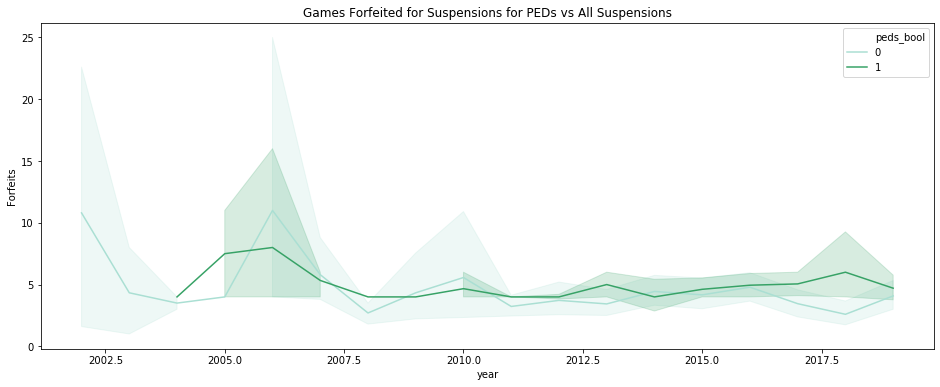

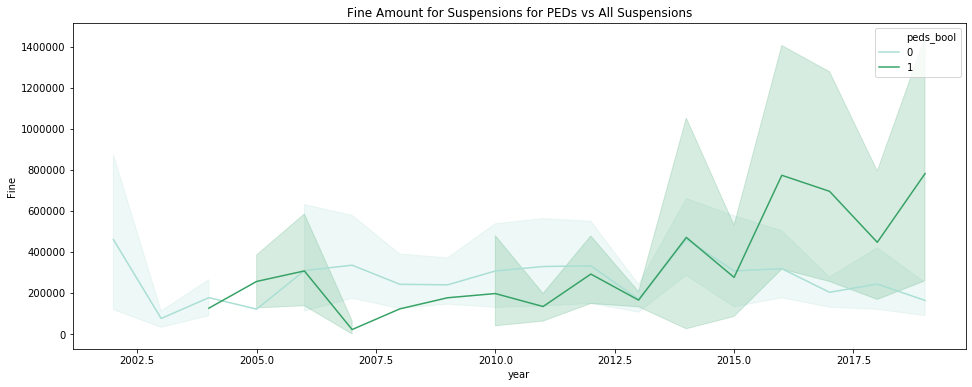

In [7]:
plt.figure(figsize=(16,6))
ax = sns.lineplot(x='year', y='Forfeits', hue='peds_bool', data=nfl_sus, palette="BuGn")
ax.set_title('Games Forfeited for Suspensions for PEDs vs All Suspensions')

plt.figure(figsize=(16,6))
ax = sns.lineplot(x='year', y='Fine', hue='peds_bool', data=nfl_sus, palette="BuGn")
ax.set_title('Fine Amount for Suspensions for PEDs vs All Suspensions')

Suspensions related to PED use (peds_bool == 1) have a higher average number of games suspended after 2011 and higher average fine amount after 2015. Can we say the same for substance abuse as well?

Text(0.5, 1.0, 'Fine Amount for Suspensions for Substance Abuse vs All Suspensions')

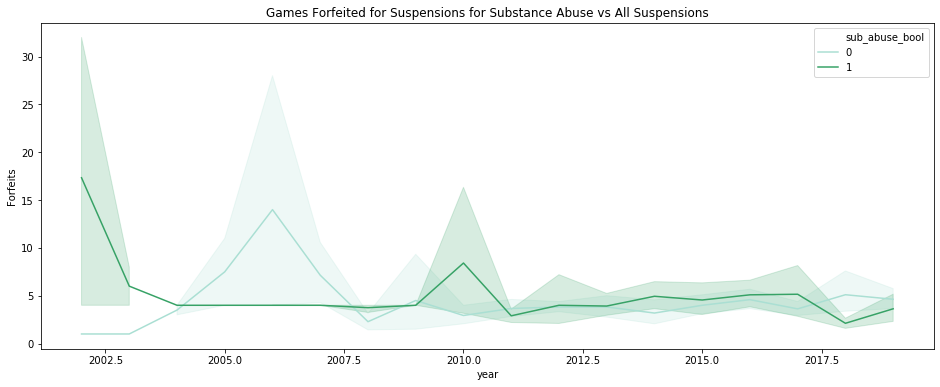

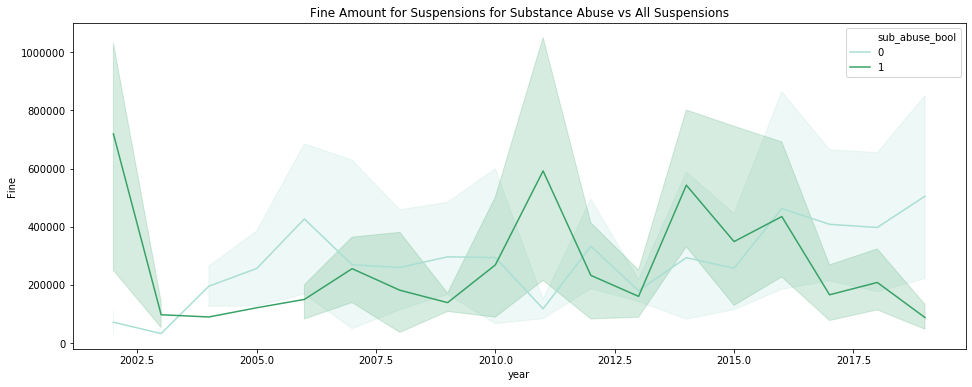

In [8]:
plt.figure(figsize=(16,6))
ax = sns.lineplot(x='year', y='Forfeits', hue='sub_abuse_bool', data=nfl_sus, palette="BuGn")
ax.set_title('Games Forfeited for Suspensions for Substance Abuse vs All Suspensions')

plt.figure(figsize=(16,6))
ax = sns.lineplot(x='year', y='Fine', hue='sub_abuse_bool', data=nfl_sus, palette="BuGn")
ax.set_title('Fine Amount for Suspensions for Substance Abuse vs All Suspensions')

No, suspensions due to substance abuse do not follow the same trends as those related to PED use. Substance abuse 
related suspensions have a lower average number of forfeited games after about 2017 and lower average fine amount 
after around 2016. What about drug use in general compared to overall suspensions?

Text(0.5, 1.0, 'Fine Amount for Suspensions for Drug Use vs All Suspensions')

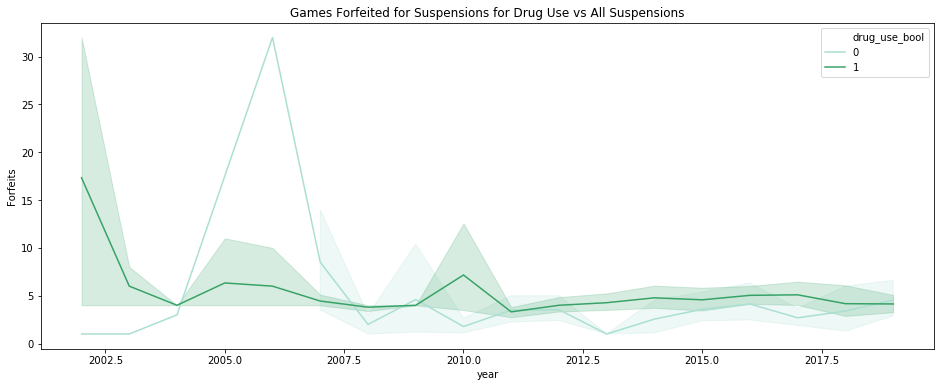

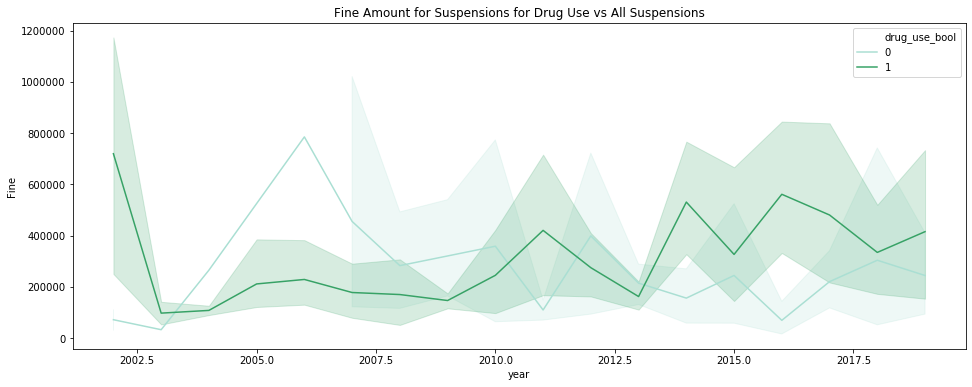

In [9]:
plt.figure(figsize=(16,6))
ax = sns.lineplot(x='year', y='Forfeits', hue='drug_use_bool', data=nfl_sus, palette="BuGn")
ax.set_title('Games Forfeited for Suspensions for Drug Use vs All Suspensions')

plt.figure(figsize=(16,6))
ax = sns.lineplot(x='year', y='Fine', hue='drug_use_bool', data=nfl_sus, palette="BuGn")
ax.set_title('Fine Amount for Suspensions for Drug Use vs All Suspensions')

When including PED use and substance abuse, the average number of forfeited games and average fine amount have been 
consistently higher than suspensions overall in recent years.

To note the variations in forfeited games and fine amounts when involving and when not involving drug use, box plots are created below.

[(0, 20)]

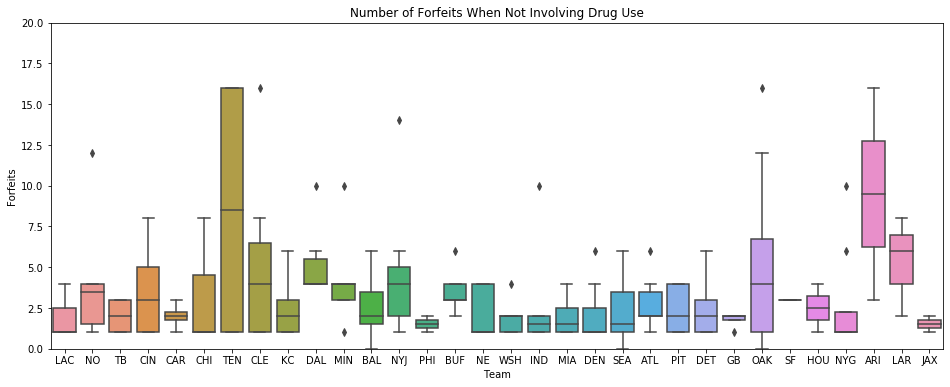

In [10]:
plt.figure(figsize=(16,6))
ax = sns.boxplot(x="Team", y="Forfeits",  data=nfl_sus[nfl_sus['drug_use_bool']=='0']);
ax.set_title("Number of Forfeits When Not Involving Drug Use")
ax.set(ylim=(0, 20))


[(0, 20)]

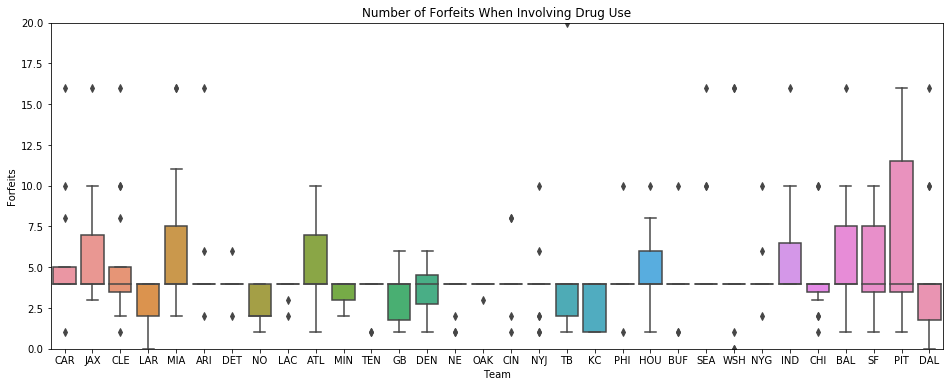

In [11]:
plt.figure(figsize=(16,6))
ax = sns.boxplot(x="Team", y="Forfeits",  data=nfl_sus[nfl_sus['drug_use_bool']=='1']);
ax.set_title("Number of Forfeits When Involving Drug Use")
ax.set(ylim=(0, 20))

[(0, 1000000)]

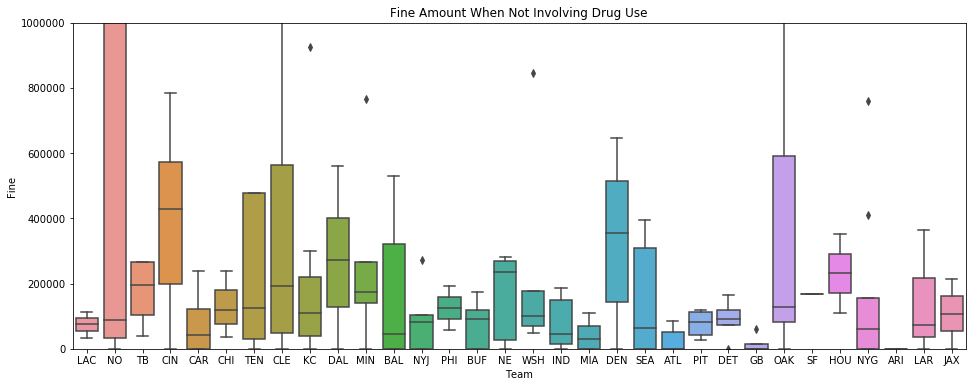

In [12]:
plt.figure(figsize=(16,6))
ax = sns.boxplot(x="Team", y="Fine",  data=nfl_sus[nfl_sus['drug_use_bool']=='0']);
ax.set_title("Fine Amount When Not Involving Drug Use")
ax.set(ylim=(0, 1000000))

[(0, 1000000)]

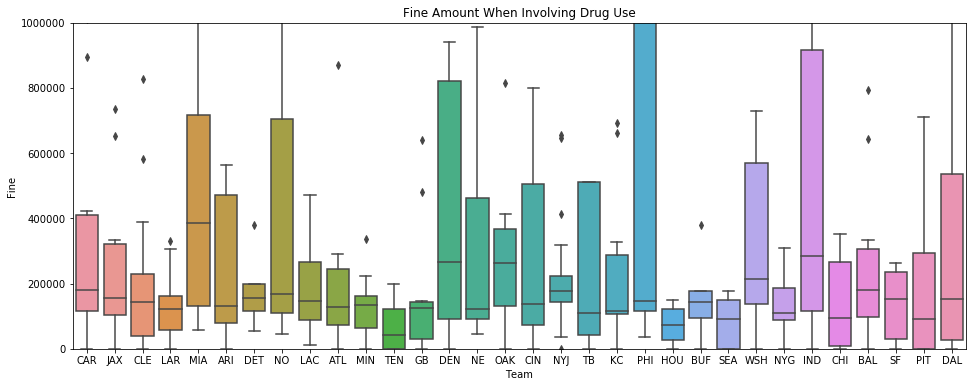

In [13]:
plt.figure(figsize=(16,6))
ax = sns.boxplot(x="Team", y="Fine",  data=nfl_sus[nfl_sus['drug_use_bool']=='1']);
ax.set_title("Fine Amount When Involving Drug Use")
ax.set(ylim=(0, 1000000))

From the box plots, the number of forfeited games seem to be higher on average yet have a lower variability when involing drug use versus not. The fine amounts seem to have a higher average and higher variabiltiy when involving drug use than when not.

### Team Infractions and Elo Ratings

Now let's see if there are any trends in the data involving the number of infractions by team and the teams' average Elo probabiltiy.


Text(0.5, 1.0, 'Number of Total Suspensions by Team')

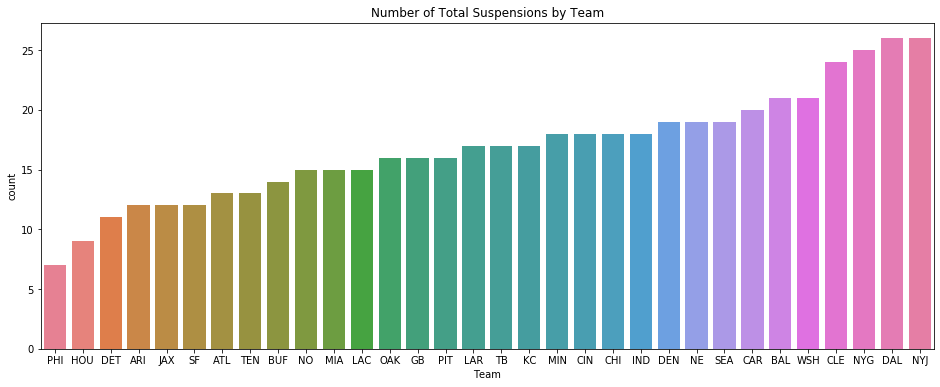

In [14]:
plt.figure(figsize=(16,6))
ax = sns.countplot(x='Team', data=nfl_sus, palette='husl', 
                  order=nfl_sus.groupby('Team')['Player'].count().sort_values().index)
ax.set_title("Number of Total Suspensions by Team")

Text(0.5, 1.0, 'Number of PEDs Suspensions vs Overall Suspensions by Team')

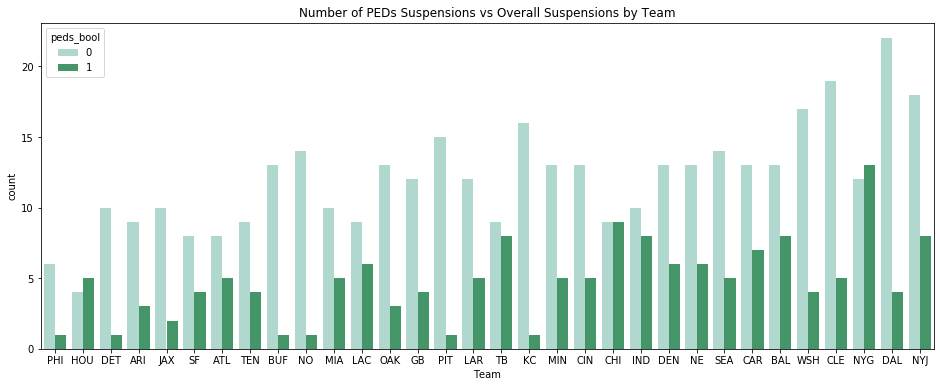

In [15]:
plt.figure(figsize=(16,6))
ax = sns.countplot(x='Team', hue='peds_bool', data=nfl_sus, palette="BuGn",
                  order=nfl_sus.groupby('Team')['Player'].count().sort_values().index)
ax.set_title("Number of PEDs Suspensions vs Overall Suspensions by Team")

The first graph plots total suspensions by team, while the second plots the total number of PEDs-related suspensions and non-PEDs-related suspensions. Both graphs are ordered by total number of suspensions. We can see that there aren't any trends with the percentage of suspensions that are related to PEDs and the total number of suspensions.

Next, I plot the average score and Elo probabilties by team at home and away.

Text(0.5, 1.0, 'Total Score by Teams at Home')

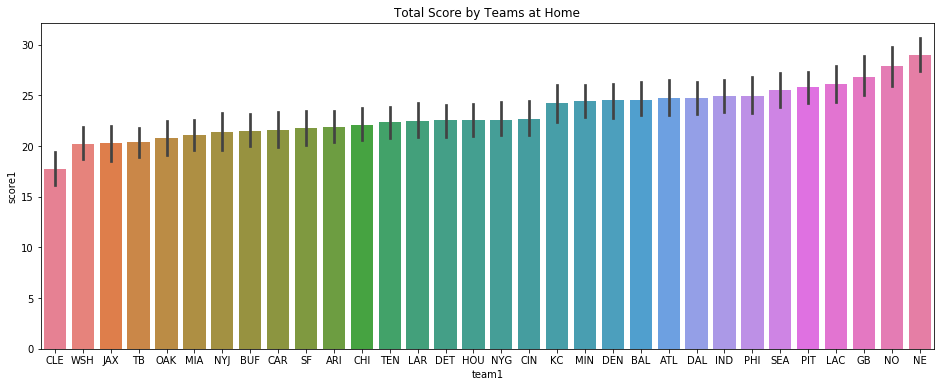

In [16]:
plt.figure(figsize=(16,6))
ax = sns.barplot(x='team1',y='score1',data=df_nfl_elo,palette="husl", 
           order=df_nfl_elo.groupby('team1')['score1'].mean().sort_values().index)
ax.set_title("Total Score by Teams at Home")

Text(0.5, 1.0, 'Elo Probability of Teams at Home')

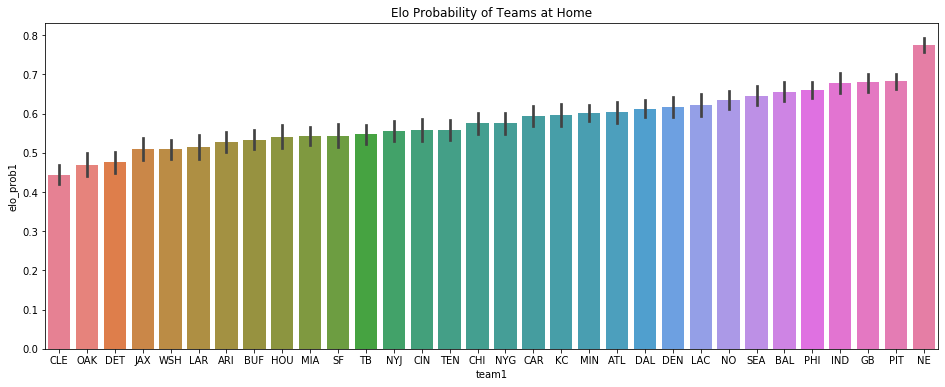

In [17]:
plt.figure(figsize=(16,6))
ax = sns.barplot(x='team1',y='elo_prob1',data=df_nfl_elo,palette="husl", 
           order=df_nfl_elo.groupby('team1')['elo_prob1'].mean().sort_values().index)
ax.set_title("Elo Probability of Teams at Home")

Text(0.5, 1.0, 'Elo Probability of Teams Away')

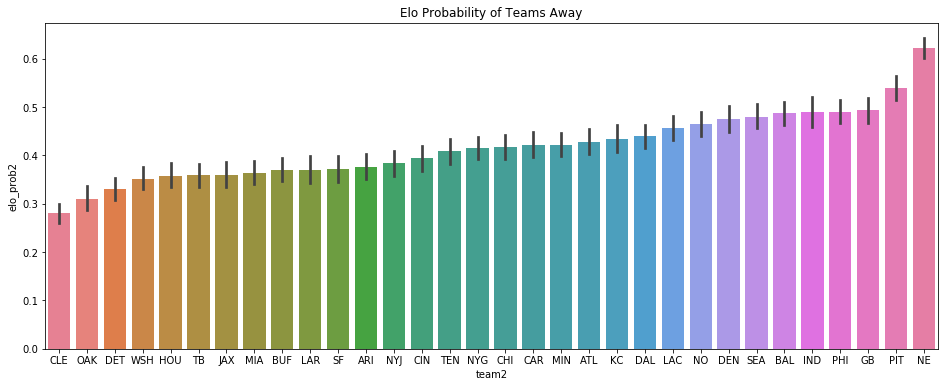

In [18]:
plt.figure(figsize=(16,6))
ax = sns.barplot(x='team2',y='elo_prob2',data=df_nfl_elo,palette="husl", 
           order=df_nfl_elo.groupby('team2')['elo_prob2'].mean().sort_values().index)
ax.set_title("Elo Probability of Teams Away")

One thing to notice is that the teams with the total number of infractions (and the teams with the highest PEDs suspensions) are not the teams with the highest Elo probabilites or scores. Yet, there also does not seem to be a strong negative correlation as well (i.e., the teams with the highest suspensions are not the teams with the lowest Elo probabilities or scores). One team that does stick out however is Cleveland, who is fourth highest in suspensions and lowest in score and Elo probability. 

To analyze this further, the percentage of PED suspensions are plotted with the Elo probability for the away team. I  chose to plot the Elo probability for away teams since these games are harder to win, and it will be clearer to see if PED use is helping raise Elo probabilities or not. 

## Hypothesis
### Is there any relationships between drug use and probability of winning?

Least squares linear regression (best fit line) is used to see if there is a linear relationship between Elo probabilites and percentage of PED or substance abuse related suspensions since I am interested in knowing if Elo probabilities decrease of increase as the percentage of PED related suspensions increase. Here we can find answers the question mentioned in the introduction. Can we say that PED use is in any way correlated to teams that have a higher chance of winning?

R^2 value: 5.1163851115827526e-05


Text(0.5, 1.0, 'Percentage of PED Suspensions and Elo Probabiltiy for Away Team, R^2 value = 5.1163851115827526e-05')

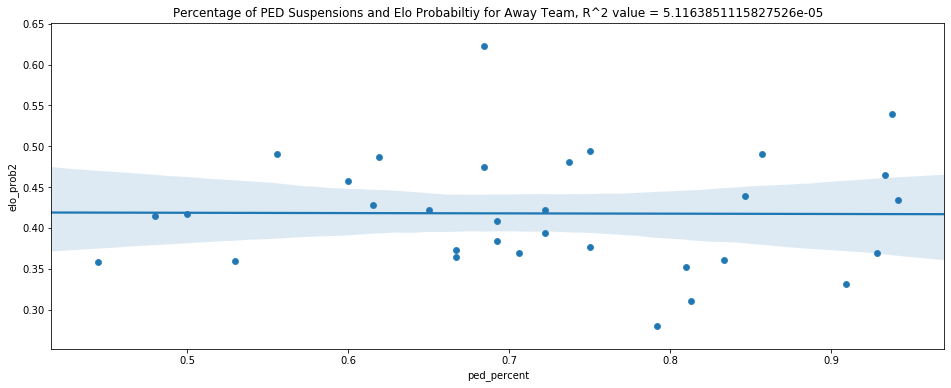

In [19]:
# team PED suspensions percentage
team_sus_groups = nfl_sus.groupby("Team")['peds_bool'].value_counts()
team_peds_bool = team_sus_groups.unstack()
team_peds_bool['sum'] = team_peds_bool['0'] + team_peds_bool['1']
team_peds_bool['ped_percent'] = team_peds_bool['0'] / team_peds_bool['sum']
team_peds_bool['no_ped_percent'] = team_peds_bool['1'] / team_peds_bool['sum']
team_peds_bool['Team_Name'] = team_peds_bool.index

# average Elo probability for away team
elo_prob2_avg = pd.DataFrame(df_nfl_elo.groupby('team2')['elo_prob2'].mean())
elo_prob2_avg.index.names = ['Team_Name']
# merge the two
team_peds_bool = team_peds_bool.merge(elo_prob2_avg, on="Team_Name")

# plot graph and best fit line
plt.figure(figsize=(16,6))
ax = sns.scatterplot(x='ped_percent',y='elo_prob2',data=team_peds_bool)

x=team_peds_bool['ped_percent']
y=team_peds_bool['elo_prob2']
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

ax = sns.regplot(x='ped_percent',y='elo_prob2',data=team_peds_bool)
print("R^2 value: {}".format(r_value**2))
ax.set_title("Percentage of PED Suspensions and Elo Probabiltiy for Away Team, R^2 value = {}".format(r_value**2))
             

There seems to be no correlation between the percentage of PED suspensions and Elo probability for the away team. So we can say that teams that have a higher percentage of PED related suspensions do not have increased nor decreased chances of winning.

What about substance abuse? Does increased substance abuse suspensions lower Elo probabilities for the away team?

R^2 value: 0.006877872149883664


Text(0.5, 1.0, 'Percentage of Substance Abuse Suspensions and Elo Probabiltiy for Away Team, R^2 value = 0.006877872149883664')

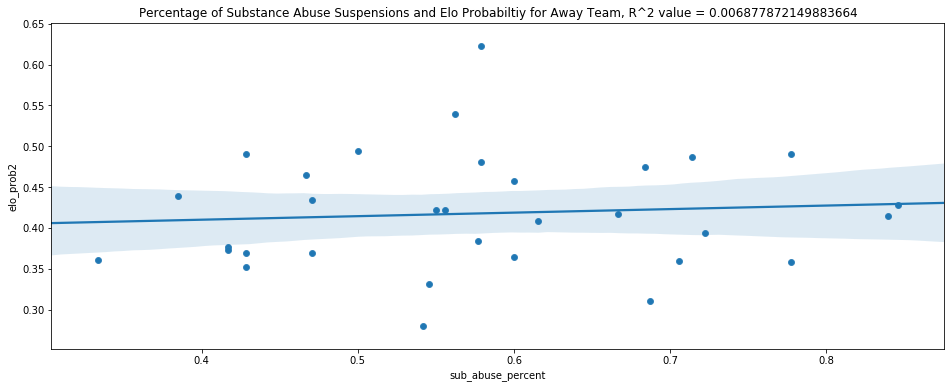

In [20]:
# team substance abuse suspensions percentage
team_sus_groups = nfl_sus.groupby("Team")['sub_abuse_bool'].value_counts()
team_sa_bool = team_sus_groups.unstack()
team_sa_bool['sum'] = team_sa_bool['0'] + team_sa_bool['1']
team_sa_bool['sub_abuse_percent'] = team_sa_bool['0'] / team_sa_bool['sum']
team_sa_bool['no_sub_abuse_percent'] = team_sa_bool['1'] / team_sa_bool['sum']
team_sa_bool['Team_Name'] = team_sa_bool.index

# average Elo probability for away team
elo_prob2_avg = pd.DataFrame(df_nfl_elo.groupby('team2')['elo_prob2'].mean())
elo_prob2_avg.index.names = ['Team_Name']

# merge the two
team_sa_bool = team_sa_bool.merge(elo_prob2_avg, on="Team_Name")

# plot
plt.figure(figsize=(16,6))
ax = sns.scatterplot(x='sub_abuse_percent',y='elo_prob2',data=team_sa_bool)

x=team_sa_bool['sub_abuse_percent']
y=team_sa_bool['elo_prob2']
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

ax = sns.regplot(x='sub_abuse_percent',y='elo_prob2',data=team_sa_bool)
print("R^2 value: {}".format(r_value**2))
ax.set_title("Percentage of Substance Abuse Suspensions and Elo Probabiltiy for Away Team, R^2 value = {}".format(r_value**2))

Just as with suspensions involving PEDs, there does not seem to be a relationship between the percentage of suspensions due to substance abuse and the probability of winning an away game. 

R^2 value: 0.0034578355703807485


Text(0.5, 0, 'Suspension count')

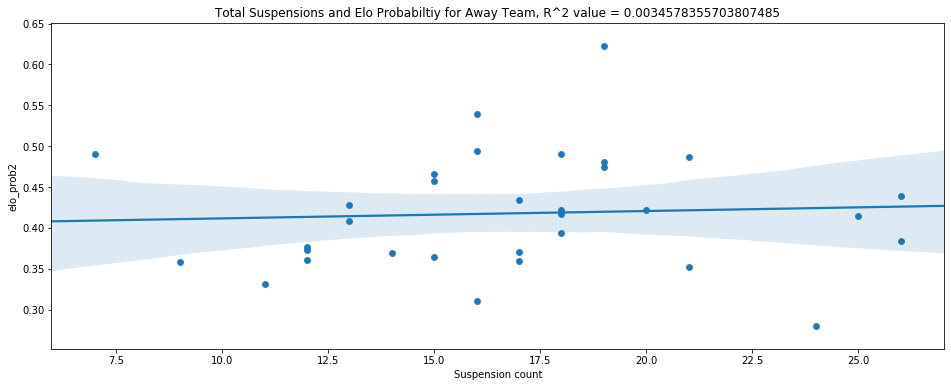

In [21]:
# plot total suspensions
plt.figure(figsize=(16,6))
ax = sns.scatterplot(x='sum',y='elo_prob2',data=team_peds_bool)

x=team_peds_bool['sum']
y=team_peds_bool['elo_prob2']
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

ax = sns.regplot(x='sum',y='elo_prob2',data=team_peds_bool)
print("R^2 value: {}".format(r_value**2))
ax.set_title("Total Suspensions and Elo Probabiltiy for Away Team, R^2 value = {}".format(r_value**2))
ax.set_xlabel("Suspension count")

There is also no relationship when looking at raw number of suspensions.

### Do players suspended due to PEDs have a higher number of games suspended and higher fine amount?

Going back to comparing suspensions that involve drug use and those that don't, let's look at the averages for the number of suspended games and fine amounts for suspensions related to PED use and 
overall suspensions.


In [22]:
print("Forfeited games and fine amount for overall suspensions:")
print(nfl_sus[nfl_sus['peds_bool']=='0']['Forfeits'].mean())
print(nfl_sus[nfl_sus['peds_bool']=='0']['Fine'].mean())

print("Forfeited games and fine amount for PED suspensions:")
print(nfl_sus[nfl_sus['peds_bool']=='1']['Forfeits'].mean())
print(nfl_sus[nfl_sus['peds_bool']=='1']['Fine'].mean())

Forfeited games and fine amount for overall suspensions:
4.176165803108808
284824.3052590674
Forfeited games and fine amount for PED suspensions:
4.882352941176471
453912.2786274509


There does seem to be a difference in games forfeited and fine amount.

What about for overall drug use?

In [23]:
print("Forfeited games and fine amount for overall suspensions:")
print(nfl_sus[nfl_sus['drug_use_bool']=='0']['Forfeits'].mean())
print(nfl_sus[nfl_sus['drug_use_bool']=='0']['Fine'].mean())

print("Forfeited games and fine amount for drug use related suspensions:")
print(nfl_sus[nfl_sus['drug_use_bool']=='1']['Forfeits'].mean())
print(nfl_sus[nfl_sus['drug_use_bool']=='1']['Fine'].mean())

Forfeited games and fine amount for overall suspensions:
3.540372670807453
241029.4913664596
Forfeited games and fine amount for drug use related suspensions:
4.732804232804233
371918.0220899471


There does seem to be a difference in the number of forfeited games and fine amount between suspensions that involve drug use and those that do not. To test this hypothesis, a t test is used to see if there is actually a difference in the means of the two samples. These samples are assumed to have unequal variances since from the boxplots shown above, the variances do not appear to be equal. 

The first two t tests are for Forfeits and Fines for suspensions not involving PEDs use vs suspensions that involve PEDs use. 

The second two t tests are for Forfeits and Fines for suspensions not involving drug use vs suspensions that involve drug use.

In [24]:
print(stats.ttest_ind(nfl_sus[nfl_sus['peds_bool']=='0']['Forfeits'],
          nfl_sus[nfl_sus['peds_bool']=='1']['Forfeits'], equal_var=False))
print(stats.ttest_ind(nfl_sus[nfl_sus['peds_bool']=='0']['Fine'],
          nfl_sus[nfl_sus['peds_bool']=='1']['Fine'], equal_var=False))

Ttest_indResult(statistic=-2.0623101600449725, pvalue=0.039778079402177945)
Ttest_indResult(statistic=-2.3179614583112333, pvalue=0.021471499856580888)


In [25]:
print(stats.ttest_ind(nfl_sus[nfl_sus['drug_use_bool']=='0']['Forfeits'],
          nfl_sus[nfl_sus['drug_use_bool']=='1']['Forfeits'],
          equal_var=False))
print(stats.ttest_ind(nfl_sus[nfl_sus['drug_use_bool']=='0']['Fine'],
          nfl_sus[nfl_sus['drug_use_bool']=='1']['Fine'],
          equal_var=False))

Ttest_indResult(statistic=-3.0451349077881735, pvalue=0.0025169414546722412)
Ttest_indResult(statistic=-2.703627289645016, pvalue=0.007100836721482534)


As we can see, all p-values are  significant, so we can conclude that there is a difference in means. Rather, drug
use suspensions do have a higher number of forfeited games and a higher fine amount.

## Conclusion

Overall, suspensions involving explicit PED use and drug use (PED use or substance abuse) do have a higher average fine amount and a higher average number of forfeited games. This suggests that the NFL punishes drug use more severely than other suspension types.  

So then are players using drugs, and more specifically PEDs, because it helps their team win? From the plots above, we can see that this is not the case, at least for those players that get caught. There does not seem to be a relationship between Elo ratings, or the team's probabiltiy of winning a game, and the percentage of PED related suspensions. There is also no relationship between suspension count and Elo probabilties, which suggests that the number of suspensions that a team has does not affect how many games they can win.

Just going from the data above, this can be a great source of inspiration for teams. You don't have to use performance enhancing drugs to win, or at the very least, even if you get caught, there doesn't seem to be many consequences to the team's win ability as a whole.